## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [39]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


/tmp/ipykernel_25522/2637987050.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

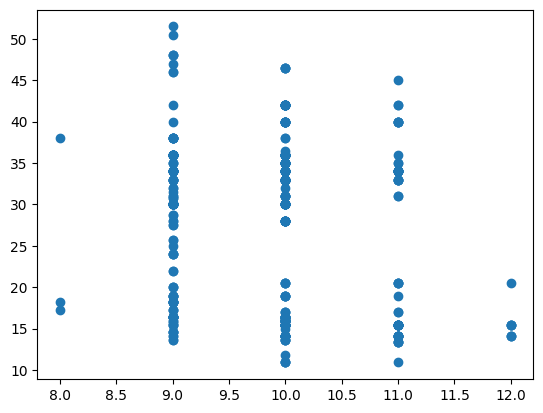

In [40]:
import matplotlib.pyplot as plt
plt.scatter('Month','Price',data=new_pumpkins)

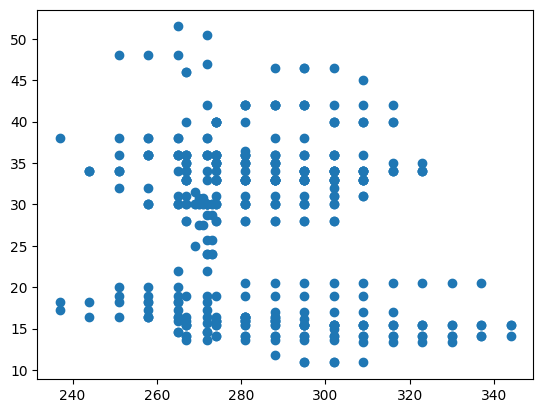

In [41]:

plt.scatter('DayOfYear','Price',data=new_pumpkins)

In [42]:
# Print  the correlation between month and price
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))

# Print  the correlation between day of the year and price
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077526
-0.1667332249274541


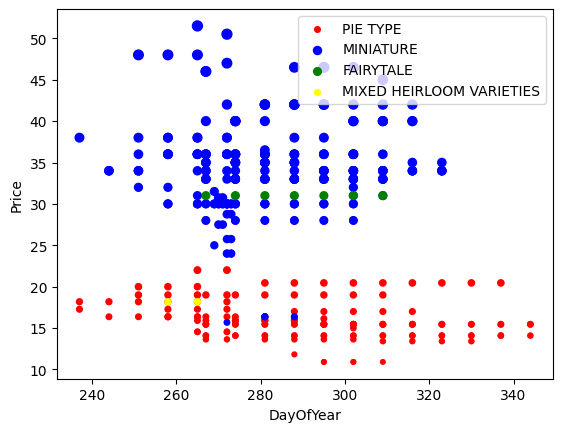

In [43]:
colors = ['red', 'blue', 'green', 'yellow']

ax= None
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear', 'Price', 'Price', ax=ax, c=colors[i], label=var)

<Axes: xlabel='Variety'>

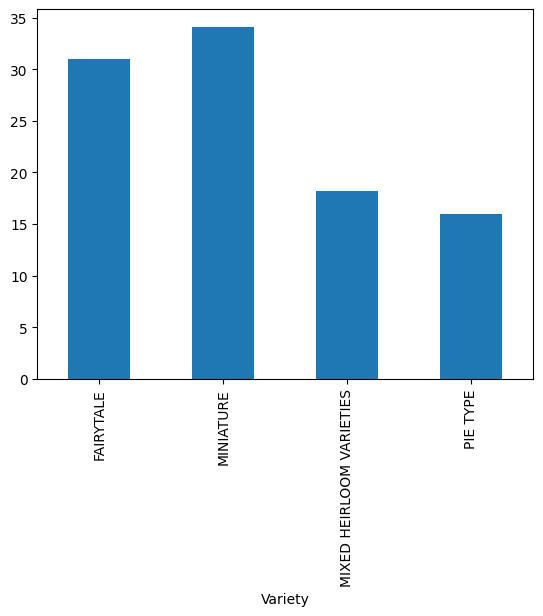

In [45]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

<Axes: xlabel='DayOfYear', ylabel='Price'>

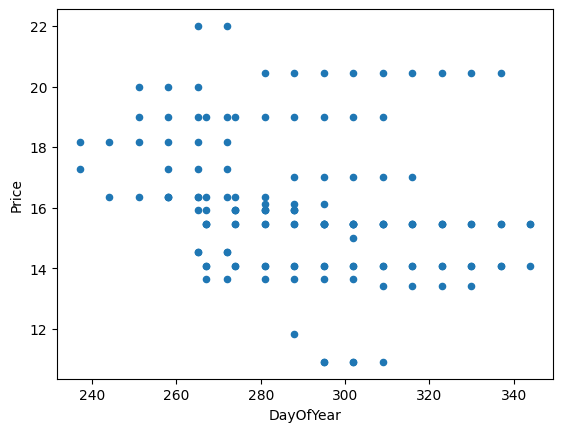

In [44]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety'] == 'PIE TYPE']
pie_pumpkins.plot.scatter("DayOfYear", 'Price')

In [46]:
print(pie_pumpkins['Month'].corr(pie_pumpkins['Price']))

print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))

-0.23841413206125747
-0.2669192282197318


In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [48]:
# Get the day of year and price in separate arrays
X= pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X.shape

(144, 1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [50]:
# Create a linear regression object and train the model wusing out training data

lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)

LinearRegression()

In [51]:
# test the model with out testing data
pred = lin_reg.predict(X_test)
pred

array([16.21096253, 16.73652536, 16.08833121, 15.35254325, 15.96569988,
       16.73652536, 16.21096253, 16.36863138, 16.61389403, 15.84306855,
       15.84306855, 15.72043723, 16.21096253, 15.5978059 , 16.45622519,
       15.72043723, 15.5978059 , 16.08833121, 15.72043723, 16.36863138,
       16.85915669, 16.21096253, 15.22991192, 16.21096253, 15.84306855,
       16.45622519, 16.08833121, 15.84306855, 15.5978059 ])

In [52]:
# To check how accurate are our predictions we use mean squared errors
mse = np.sqrt(mean_squared_error(y_test, pred))

# Print mean squared error in an easy to read format
print(f'Mean error: {mse:,.3f} ({mse/np.mean(pred)*100:.3f}%)')

Mean error: 2.769 (17.239%)


In [54]:
#anothe indicator of model quality id coefficient of determination
score = lin_reg.score(X_train, y_train)
print('Model determination: ', score)

Model determination:  0.04460606335028361


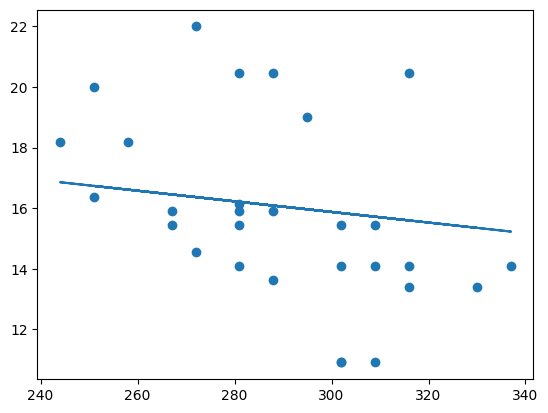

In [53]:
#creaa a scatter plot using our test data and add a line to the plot with our predicton
plt.scatter(X_test, y_test)

plt.plot(X_test, pred)

In [55]:
# print the slope and the intercept
print(f"y = {lin_reg.coef_[0]}x + {lin_reg.intercept_}")

y = -0.017518760953105x + 21.133734359909326


In [56]:
# show prediction of pumpkin price on a specifict day of the year
lin_reg.predict([[256]])

array([16.64893156])

Mean error: 2.730 (17.042%)


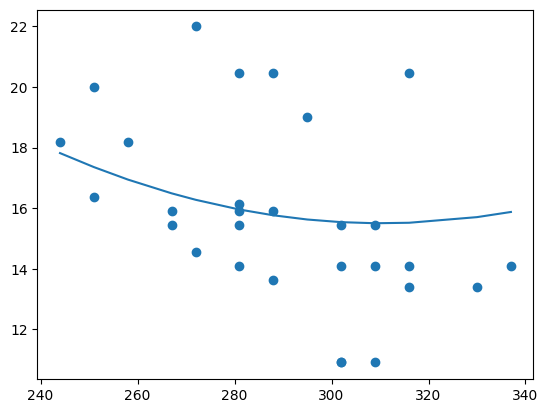

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#build a polynomial regression pipeline and use it to build the model
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

#test the model with out test data
pred = pipeline.predict(X_test)

# calculate and print mean squarred errro
mse = np.sqrt(mean_squared_error(y_test, pred))

# Print mean squared error in an easy to read format
print(f'Mean error: {mse:,.3f} ({mse/np.mean(pred)*100:.3f}%)')

#plot the results
plt.scatter(X_test, y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))


In [58]:
#anothe indicator of model quality id coefficient of determination
score = lin_reg.score(X_train, y_train)
print('Model determination: ', score)

Model determination:  0.04460606335028361
